<a href="https://colab.research.google.com/github/cesl11/online_customer_behavior/blob/main/randomized_grid_and_second_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('events.csv') # dataframe previamente procesado
df.head()

,abandoned_cart,session_duration,hour,num_events,num_product_actions,last_action_add,last_action_click,last_action_detail,last_action_purchase,last_action_remove,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,False,0,19,1,0,False,False,False,False,False,True,False,False,False,False,False,False
1,False,0,11,1,0,False,False,False,False,False,False,True,False,False,False,False,False
2,False,499,21,7,3,False,False,True,False,False,False,False,False,False,False,True,False
3,False,253,9,3,0,False,False,False,False,False,False,False,False,False,True,False,False
4,False,0,6,1,0,False,False,False,False,False,True,False,False,False,False,False,False


In [3]:
df.replace(np.nan, False)
for col in range(10,17):
  df.iloc[:,col] = df.iloc[:,col].astype(int)

<ipython-input-3-5b02ad7db5b3>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         1
1         0
2         0
3         0
4         1
         ..
443655    0
443656    0
443657    0
443658    0
443659    0
Name: day_0, Length: 443660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,col] = df.iloc[:,col].astype(int)
<ipython-input-3-5b02ad7db5b3>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         0
1         1
2         0
3         0
4         0
         ..
443655    0
443656    0
443657    1
443658    1
443659    0
Name: day_1, Length: 443660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,col] = df.iloc[:,col].astype(int)
<ipython-input-3-5b02ad7db5b3>:3: FutureWarning: Setting an item of incompatible d

In [4]:
for c in range(5,10):
  df.iloc[:,c] = df.iloc[:,c].astype(int)

<ipython-input-4-5ec720cc4cc4>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         0
1         0
2         0
3         0
4         0
         ..
443655    0
443656    0
443657    0
443658    0
443659    0
Name: last_action_add, Length: 443660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,c] = df.iloc[:,c].astype(int)
<ipython-input-4-5ec720cc4cc4>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         0
1         0
2         0
3         0
4         0
         ..
443655    0
443656    0
443657    0
443658    0
443659    0
Name: last_action_click, Length: 443660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:,c] = df.iloc[:,c].astype(int)
<ipython-input-4-5ec720cc4cc4>:2: FutureWarning: Setting an item of 

In [5]:
df.head()

,abandoned_cart,session_duration,hour,num_events,num_product_actions,last_action_add,last_action_click,last_action_detail,last_action_purchase,last_action_remove,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,False,0,19,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,False,0,11,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,False,499,21,7,3,0,0,1,0,0,0,0,0,0,0,1,0
3,False,253,9,3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,False,0,6,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
# variables dependiente y predictora
X = df.drop(columns=["abandoned_cart"])
y = df["abandoned_cart"].astype(int)

In [7]:
  # conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Duplica la clase minoritaria al 50% de la mayoritaria
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
  # subsampleo de los datos para hyperparameter tuning
  X_train_small, y_train_small = resample(
    X_train,
    y_train,
    n_samples=100000,
    random_state=42
)

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [10]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [11]:
randomized_search = RandomizedSearchCV(
    rf,
    param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [12]:
randomized_search.fit(X_train_small, y_train_small)
# mejor modelo encontrado
best_rf = randomized_search.best_estimator_
print('Best parameters:', randomized_search.best_params_)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score on Test Set: {roc_auc:.4f}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
ROC-AUC Score on Test Set: 0.9128


In [13]:
  # una vez encontrados los mejores hiperparámetros se entrena un nuevo modelo con ellos en el dataset completo
final_rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [14]:
  # evaluación
y_pred_proba_final = final_rf.predict_proba(X_test)[:, 1]
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f'Final ROC-AUC Score on Test Set: {roc_auc_final:.4f}')

Final ROC-AUC Score on Test Set: 0.9188


<ipython-input-17-b03aeb23e4bb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


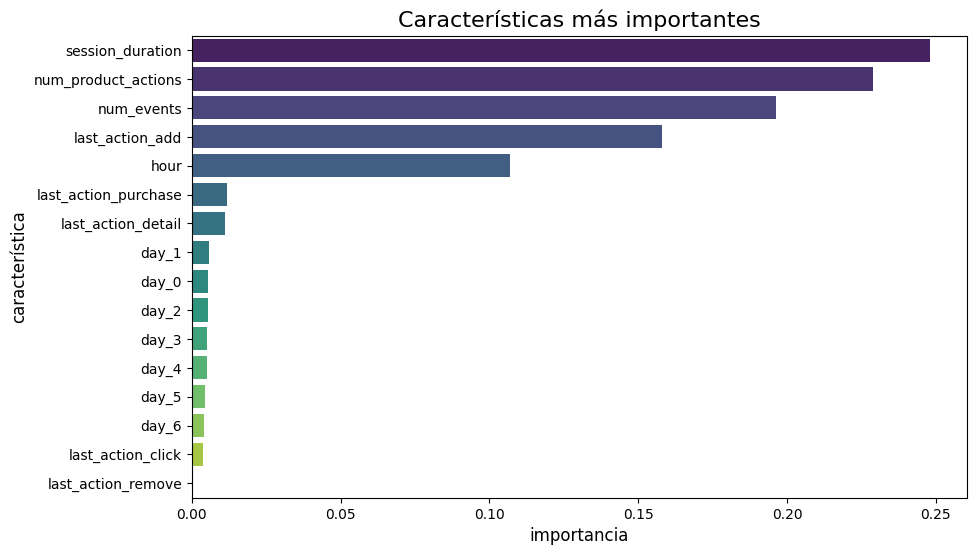

In [17]:
# importancia de las características
feature_importances = final_rf.feature_importances_

# DataFrame para visualizacion
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# grafica
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Características más importantes', fontsize=16)
plt.xlabel('importancia', fontsize=12)
plt.ylabel('característica', fontsize=12)
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     83262
           1       0.36      0.55      0.43      5470

    accuracy                           0.91     88732
   macro avg       0.66      0.74      0.69     88732
weighted avg       0.93      0.91      0.92     88732



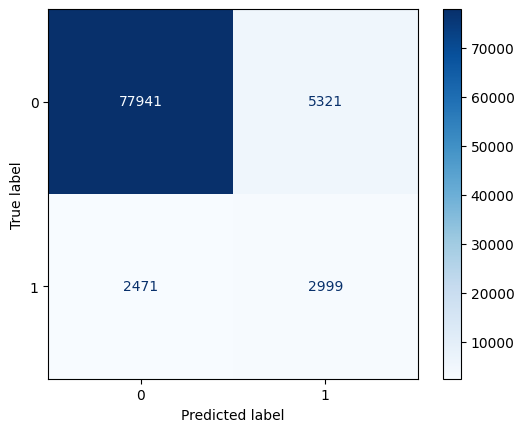

In [23]:
  # prueba adicional, determinación y ajuste de umbral de decisión
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_final)

# umbral optimo para puntuación f-1 de la clase 1 (abandono)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# aplicar
y_pred_adj = (y_pred_proba_final >= best_threshold).astype(int)

# evaluacion del nuevo umbral
print(classification_report(y_test, y_pred_adj))
conf_mtx =confusion_matrix(y_test, y_pred_adj)
cf_disp = ConfusionMatrixDisplay(conf_mtx, display_labels=final_rf.classes_)
cf_disp.plot(cmap='Blues')
plt.show()